# Character Predicting with RNN
---

Codes are writen by simonjisu.
* Simonjisu Blog: https://simonjisu.github.io
* Project Numpy with NN: https://github.com/simonjisu/NUMPYwithNN



## Goal
Writing 'Hello world! Nice to meet you! I love iron-man' using RNN with numpy

|Input||Output|
|:-:|:-:|:-:|
|h|$\rightarrow$|e|
|e|$\rightarrow$|l|
|l|$\rightarrow$|l|
|l|$\rightarrow$|o|
|$\vdots$|$\vdots$|$\vdots$|
|m|$\rightarrow$|a|
|a|$\rightarrow$|n|


## Packages

In [1]:
import os
import sys
dir_path = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(dir_path)

In [2]:
import numpy as np
from common.SimpleRNN import Single_layer_RNN
from common.optimizer import Adam
from common.train_graph import loss_graph
np.random.seed(1234)

## DATA

In [3]:
x = 'hello world! nice to meet you! i love iron-man'

### Encoder

In [4]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x):
        encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        return encoded_data
    
    def decode(self, x, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

Change our data to one-hot encoding data by single character. 

In [5]:
encoder = chr_coding()
encoder.fit(x)
one_hot_data = encoder.encode(x)

print('data shape:', one_hot_data.shape)

data shape: (46, 19)


## Parameters

In [6]:
NUM_EPOCHS = 600
PRINT_EPOCH = 30
SEQ_LEN = one_hot_data.shape[0] - 1
INPUT_SIZE = one_hot_data.shape[1]
OUTPUT_SIZE = one_hot_data.shape[1]
HIDDEN_SIZE = 20
BPTT_TRUNCATE = 5

# Backpropagation Through Time Truncate: 
# A fixed number of steps to lookback past data in BPTT

## Get Training Datas

In [7]:
train_x = one_hot_data[:-1]
train_y = one_hot_data[1:]

In [8]:
train_x.shape

(45, 19)

## Call RNN module & Optimizer Setting

Basic Settings of **Single_layer_RNN**

* input_size: input layer size
* hidden_size: hidden layer size
* output_size: output layer size
* bptt_truncate: if you want to use it, use backward_truncate method when you doing backward, default=0
* activation_func: if use "tanh", params will initialize as Xavier, use "relu", initialize as He, default="tanh"

In [9]:
# accuracy calculation function
def get_accuracy(x, test_string):
    bool_ = np.array(list(x))[1:] == np.array(list(test_string))[1:]
    return bool_.sum() / len(bool_)

In [10]:
def train(rnn, optim, option=True, print_epoch=20):
    """
    option:
    * True: do backward
    * False: do backward_truncate
    """
    total_loss_list = []
    total_acc_list = []
    for epoch in range(NUM_EPOCHS):
        test_string = 'h'
        # forward
        total_loss = rnn.loss(train_x, train_y)

        # backward
        if option:
            rnn.backward()
        else:
            rnn.backward_truncate()

        optim.update(rnn.params, rnn.params_summ)

        # test string
        predicted_idx = rnn.predict(train_x)
        for idx in predicted_idx:
            test_string += encoder.decode(idx)

        # get accuracy
        acc = get_accuracy(x, test_string)

        if epoch % print_epoch == 0:
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))
        elif epoch == (NUM_EPOCHS-1):
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))

        total_loss_list.append(total_loss)
        total_acc_list.append(acc)
    return total_loss_list, total_acc_list

### Using BPTT

In [11]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE)
optim = Adam()

In [12]:
total_loss_list, total_acc_list = train(rnn, optim, option=True, print_epoch=PRINT_EPOCH)

#0, Loss: 2.988448, Acc: 0.066667, Test_string: "heolydvnllyhnvlydnvnl!vnnlldnnoldunoytvnlyynne"
#30, Loss: 2.685436, Acc: 0.177778, Test_string: "heolyy!nvly!nvily!nnla!tnnld!nolyunnoy!dnnlm!n"
#60, Loss: 2.472298, Acc: 0.288889, Test_string: "hevlydunvly!tnnld!nnycdttnyd!nnlyuovi !unncm!n"
#90, Loss: 2.246952, Acc: 0.400000, Test_string: "he lleuovld!tnnld!nnycettnydutolyuovo mtnncman"
#120, Loss: 2.001057, Acc: 0.444444, Test_string: "he lle!ovld!tnnld!nnymettnyduool  ove mtnocman"
#150, Loss: 1.743939, Acc: 0.622222, Test_string: "he ll !ovld!tnnle!toymett youo l love mtnocman"
#180, Loss: 1.486476, Acc: 0.800000, Test_string: "he ll wovld!tnoce!to mett you! l love iton-man"
#210, Loss: 1.246447, Acc: 0.844444, Test_string: "he ll world!tnoce!to me t you! l love iron-man"
#240, Loss: 1.035401, Acc: 0.933333, Test_string: "helll world!tnice to meet you! l love iron-man"
#270, Loss: 0.852027, Acc: 0.977778, Test_string: "helll world! nice to meet you! i love iron-man"
#300, Loss: 0.6

In [13]:
rnn.gradient_check(train_x, train_y)

W_xh:0.027203514319849974
W_hh:0.064202299724815
W_hy:0.09685324759403358
b_h:0.002765335923454043
b_y:0.0020488658736492046


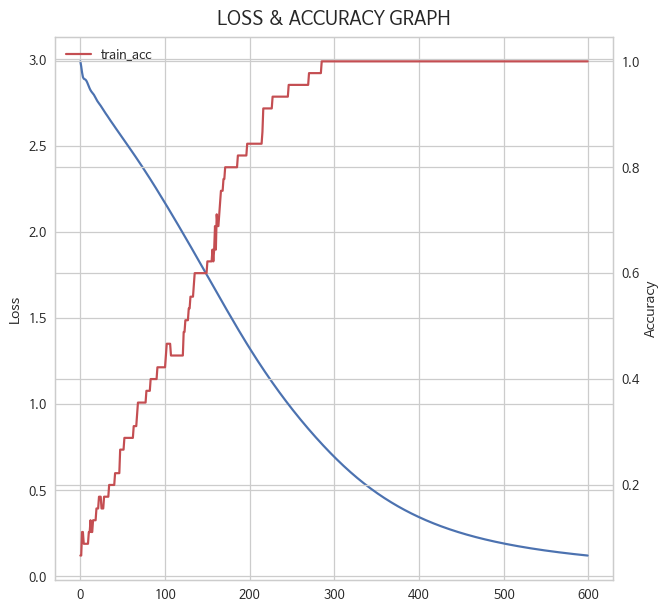

In [14]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using BPTT-Truncate

In [15]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE)
optim = Adam()

In [16]:
total_loss_list, total_acc_list = train(rnn, optim, option=False, print_epoch=PRINT_EPOCH)

#0, Loss: 3.067947, Acc: 0.000000, Test_string: "hhradohnvhnnutmalchnhhturc -rdchmacohchmalurdt"
#30, Loss: 2.808137, Acc: 0.111111, Test_string: "hhrlcvhnvhnn!tichchn htul  mrynhmacchchmachwyt"
#60, Loss: 2.582015, Acc: 0.311111, Test_string: "hvmac h vhd!!tice e  h ee  moa iemo oa ma uwa "
#90, Loss: 2.360437, Acc: 0.355556, Test_string: "hyme  o  hdd!iice eo ooeo  eoo i eooo o l uwdn"
#120, Loss: 2.205561, Acc: 0.444444, Test_string: "hyeeo o rdd!nnice eo o eo  oo!ni e eo o ld!!nn"
#150, Loss: 2.018125, Acc: 0.466667, Test_string: "hyeeo o rdd!nnice eo e ee  or! e eo o o ld!!nn"
#180, Loss: 1.891030, Acc: 0.466667, Test_string: "hyeeo o rod!ncice eo o eo  or! e eo o o od!-nn"
#210, Loss: 1.770151, Acc: 0.488889, Test_string: "hyeeo o rod!ncice eo e eo  or! i eo o o rd--nn"
#240, Loss: 1.700314, Acc: 0.511111, Test_string: "heelo o ro !niece eo e eo  or! i eo o o rd-mnn"
#270, Loss: 1.652164, Acc: 0.577778, Test_string: "heelo o ro i i ce eo o eo  or! i eo e o od-man"
#300, Loss: 1.5

In [17]:
rnn.gradient_check(train_x, train_y)

W_xh:0.6040608388724417
W_hh:1.3585945037314064
W_hy:0.23097076410422793
b_h:0.11847797462505305
b_y:0.007084893860855985


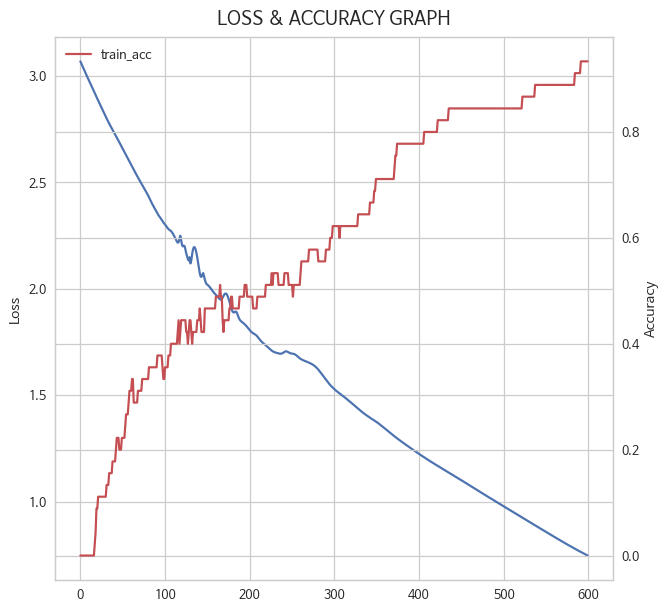

In [18]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using ReLu as activation functions

In [19]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE,
                       activation_func='relu')
optim = Adam()

In [20]:
total_loss_list, total_acc_list = train(rnn, optim, option=True, print_epoch=PRINT_EPOCH)

#0, Loss: 7.497058, Acc: 0.088889, Test_string: "hmm-wotwttmwtttwtttttttoootootoooooooooooooooo"
#30, Loss: 3.067247, Acc: 0.022222, Test_string: "hmm-wutwttmottnwtmnwuamm-lt--amdmntvt!e!n-!ttw"
#60, Loss: 2.918872, Acc: 0.088889, Test_string: "hmm-wotwttmotnnwtmnwutmmowtovamdmntvt!t!n-!ttn"
#90, Loss: 2.805615, Acc: 0.133333, Test_string: "hmm-wotwttmotnnctonwutmoontova emntva!enn- ttn"
#120, Loss: 2.685841, Acc: 0.155556, Test_string: "hmm-iotwttmotnn ton!oteoontova e ntva!enl- tmn"
#150, Loss: 2.560744, Acc: 0.155556, Test_string: "hmm-iotwttmotnn tonno eonntov  e ntv me l- een"
#180, Loss: 2.414934, Acc: 0.266667, Test_string: "hmm-iotwol o nn eonno eonlto   i ltv me l- een"
#210, Loss: 2.251571, Acc: 0.266667, Test_string: "hem-ioewoo e n   oti  eono     i l v ee l- een"
#240, Loss: 2.101192, Acc: 0.288889, Test_string: "hem-iotwoo e n   oto  enno     i   v mi l- een"
#270, Loss: 1.960208, Acc: 0.333333, Test_string: "hemiiotwoo o no eoto  enno   e i l v mi l- een"
#300, Loss: 1.8

In [21]:
rnn.gradient_check(train_x, train_y)

W_xh:0.6000790441842232
W_hh:4.214903365091313
W_hy:0.47766636884355823
b_h:0.12745942057085236
b_y:0.011407850588034046


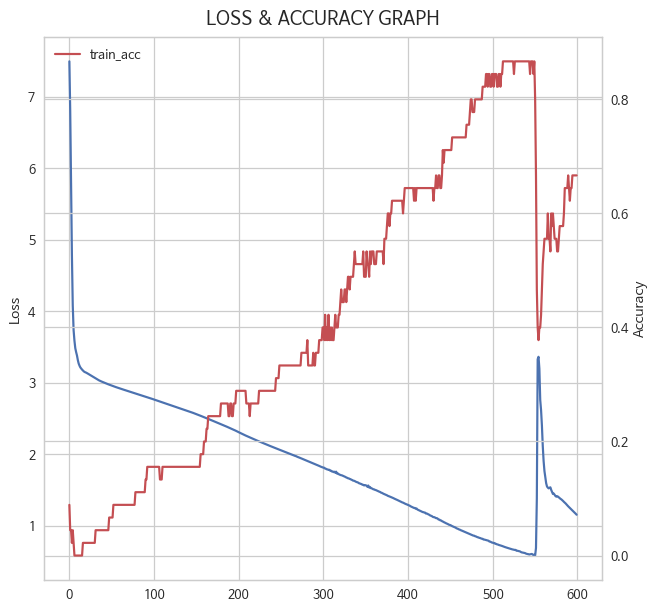

In [22]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)